In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import rgb2gray
from sklearn.linear_model import Ridge
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.models import Model
from keras.utils import to_categorical

# Load pre-trained InceptionV3 model
model = InceptionV3(weights='imagenet')

def generate_perturbed_images(image, num_samples=1000, segments=100):
    perturbed_images = []
    for _ in range(num_samples):
        # Perturb the image by randomly modifying pixels within each segment
        perturbed_image = np.copy(image)
        for segment in np.unique(segments):
            mask = segments == segment
            perturbed_image[mask] = np.random.uniform(0, 255, size=perturbed_image[mask].shape)
        perturbed_images.append(perturbed_image)
    return preprocess_input(np.array(perturbed_images))

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

# Function to compute model predictions for perturbed images
def predict_fn(perturbed_images):
    predictions = model.predict(perturbed_images)
    return predictions

# Function to fit an interpretable model to explain the predictions
def fit_interpretable_model(features, predictions):
    model = Ridge(alpha=0.1)
    model.fit(features, predictions)
    return model

# Function to explain an image prediction using LIME
def explain_image(image, model, num_features=5):
    # Perform superpixel segmentation
    segments = slic(image, n_segments=100, compactness=10)

    # Generate perturbed images
    perturbed_images = generate_perturbed_images(image)

    # Compute model predictions for perturbed images
    perturbed_predictions = predict_fn(perturbed_images)

    # Compute features (superpixel intensity values) for perturbed images
    features = np.mean(perturbed_images[:, :, :, :], axis=(1, 2))

    # Fit an interpretable model to explain the predictions
    interpretable_model = fit_interpretable_model(features, perturbed_predictions)

    # Get coefficients of the interpretable model
    feature_importances = interpretable_model.coef_

    # Select top features
    top_features_indices = np.argsort(np.abs(feature_importances))[::-1][:num_features]

    return segments, top_features_indices

# Select an image from the test set
image_path = 'Image\download.jpeg'
image = preprocess_image(image_path)

# Explain the image prediction using LIME
segments, top_features_indices = explain_image(image, model)

# Visualize the explanation
plt.imshow(segments)
plt.show()


ValueError: Input 0 of layer "inception_v3" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(32, 1, 299, 299, 3)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.segmentation import mark_boundaries
from lime_12 import lime_image
from PIL import Image

# Load the pre-trained InceptionV3 model
model = InceptionV3(weights='imagenet')

# Define the classifier function
def classifier_fn(images):
    # Preprocess images
    preprocessed_images = preprocess_input(images)
    # Get model predictions
    predictions = model.predict(preprocessed_images)
    return predictions

# Load an example image
image_path = "Image\cock2.jpeg"
image = Image.open(image_path)
image = np.array(image)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the top 5 predictions for the example image
explanation = explainer.explain_instance(image, classifier_fn, top_labels=5)

# Plot the explanation for each of the top 5 predictions
for label in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=10, hide_rest=False)
    plt.figure()
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"Explanation for label {label}")
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: in user code:

    File "C:\Users\royan\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\royan\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\royan\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\royan\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\royan\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\royan\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "inception_v3" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 193, 200, 3)


1. Generate superpixel areas
2. Create perturbed images by randomly filling some of the superpixel areas with a solid black color
3. For each perturbed image:
    a. Make predictions for the perturbed image
    b. Create weights based on the difference between the perturbed image and the original image (smaller distance == larger weight)
4. Fit a simple interpretable model using the predictions on all perturbed images and the created weights.
5. Define the number of superpixels that should be plotted and plot the superpixels with the highest importance in the simple model (i.e. coefficient if a Linear Regression is used).

In [1]:
import numpy as np
import cv2
from skimage.segmentation import slic, mark_boundaries, quickshift
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Step 1: Generate Superpixel Areas
def generate_superpixels(image):
    resized_image = cv2.resize(image, (299, 299))
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    superpixels = quickshift(resized_image_rgb, kernel_size=4, max_dist=200, ratio=0.2)
    return superpixels

# Step 2: Create Perturbed Images
def create_perturbed_images(image, superpixels, num_perturbations=100):
    resized_image = cv2.resize(image, (299, 299))
    perturbed_images = []
    perturbations = []
    for _ in range(num_perturbations):
        perturbed_image = np.copy(resized_image)
        perturbation = np.ones(superpixels.shape)
        for segment_id in np.unique(superpixels):
            if np.random.rand() < 0.5:
                perturbed_image[superpixels == segment_id] = 0
                perturbation[superpixels == segment_id] = 0
        perturbed_images.append(perturbed_image)
        perturbations.append(perturbation)
    return np.array(perturbed_images), np.array(perturbations)

# Step 3: Prediction and Weight Calculation
def predict_and_calculate_weights(images, perturbations, model, original_image):
    predictions = []
    weights = []
    original_image_preprocessed = preprocess_input(cv2.resize(original_image, (299, 299)))
    for image, perturbation in zip(images, perturbations):
        image_preprocessed = preprocess_input(image)
        prediction = model.predict(np.expand_dims(image_preprocessed, axis=0))
        predictions.append(prediction.flatten())
        
        # Calculate the distance between the perturbation and the original superpixels
        distance = np.linalg.norm(perturbation - 1)  # 1 represents the original unperturbed superpixels
        weight = np.exp(-distance**2 / (2 * 0.25**2))
        weights.append(weight)
    return np.array(predictions), np.array(weights)

# Step 4: Fit a Simple Interpretable Model
def fit_interpretable_model(predictions, weights):
    model = LinearRegression()
    model.fit(predictions, weights)
    return model

# Step 5: Identify Important Superpixels
def plot_important_segments(image, superpixels, model, num_segments_to_plot=5):
    coefficients = model.coef_
    segment_coefficients = np.zeros(len(np.unique(superpixels)))

    for idx, segment_id in enumerate(np.unique(superpixels)):
        segment_coefficients[idx] = coefficients[idx]
    
    important_segments = np.argsort(-np.abs(segment_coefficients))[:num_segments_to_plot]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    combined_segment = np.zeros_like(image)
    for idx in important_segments:
        segment = np.zeros_like(image)
        segment[superpixels == idx] = image[superpixels == idx]
        combined_segment += segment

    combined_segment = np.clip(combined_segment, 0, 255)

    plt.imshow(combined_segment.astype(np.uint8))
    plt.title('Important Segments')
    plt.axis('off')

    plt.show()
    return combined_segment

import json
with open("imagenet_class_index.json") as f:
    class_names = json.load(f)

model = InceptionV3(weights='imagenet', include_top=True)

original_image = cv2.imread('Image\cock-n01514668\n01514668_1208.JPEG')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_resized = cv2.resize(original_image, (299, 299))
original_image_preprocessed = preprocess_input(original_image_resized)

superpixels = generate_superpixels(original_image)

def plot_superpixel_image(image, superpixels):
    superpixels_resized = cv2.resize(superpixels, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(image, superpixels_resized))
    plt.axis('off')
    plt.show()

plot_superpixel_image(original_image, superpixels)

perturbed_images, perturbations = create_perturbed_images(original_image, superpixels)

perturbed_images_resized = [cv2.resize(img, (299, 299)) for img in perturbed_images]

predictions, weights = predict_and_calculate_weights(perturbed_images_resized, perturbations, model, original_image_preprocessed)

predictions_flat = predictions.reshape(-1, predictions.shape[-1])
interpretable_model = fit_interpretable_model(predictions_flat, weights)

combined_segment = plot_important_segments(original_image_resized, superpixels, interpretable_model)
combined_segment_preprocessed = preprocess_input(np.expand_dims(combined_segment, axis=0))

combined_segment_predictions = model.predict(combined_segment_preprocessed)

top_predicted_classes = np.argsort(-combined_segment_predictions[0])[:5]

print("Top 5 Predicted Classes:")
for idx in top_predicted_classes:
    class_name = class_names[str(idx)][1]
    probability = combined_segment_predictions[0][idx]
    print(f"{class_name}: {probability:.2f}")


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


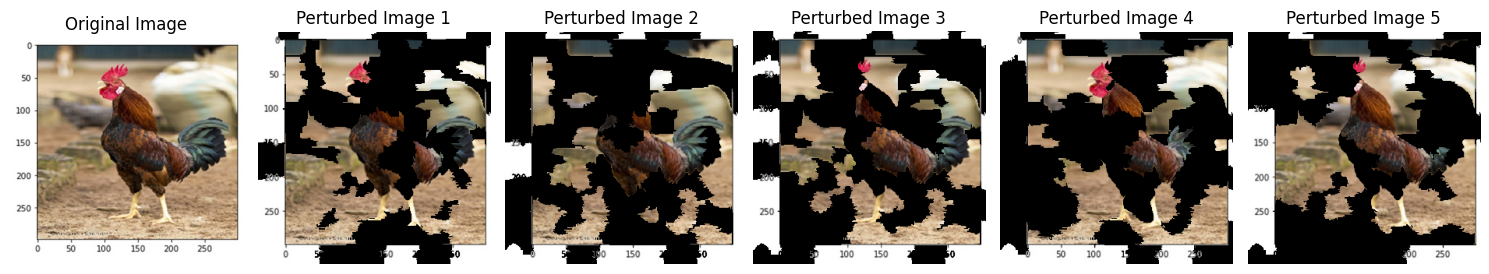

In [19]:


# Step 2: Create Perturbed Images
perturbed_images = create_perturbed_images(original_image, superpixels)


num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot + 1, figsize=(15, 5))


axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')


for i in range(num_images_to_plot):
    axes[i + 1].imshow(perturbed_images[i])
    axes[i + 1].set_title(f'Perturbed Image {i+1}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()


In [20]:
def check_predictions(model, perturbed_images, original_image_preprocessed, class_names, num_predictions=5):
    for idx, perturbed_image in enumerate(perturbed_images):
        
        perturbed_image_preprocessed = preprocess_input(perturbed_image)
        predictions = model.predict(np.expand_dims(perturbed_image_preprocessed, axis=0))
        print(f"\nPerturbed Image {idx + 1} Predictions:")
        print_top_predictions(predictions, class_names, num_predictions)
        
def print_top_predictions(predictions, class_names, num_predictions=5):
    top_indices = np.argsort(-predictions)[0][:num_predictions]
    for idx in top_indices:
        class_name = class_names[str(idx)][1]
        precision = predictions[0][idx]
        print(f'{class_name}: {precision:.2f}')



with open("imagenet_class_index.json") as f:
    class_names = json.load(f)


perturbed_images = create_perturbed_images(original_image, superpixels)
check_predictions(model, perturbed_images, original_image_preprocessed, class_names)

1/1 [==============================] - 0s 127ms/step

Perturbed Image 1 Predictions:
tray: 0.06
coral_fungus: 0.05
black_grouse: 0.04
jigsaw_puzzle: 0.04
wall_clock: 0.03
1/1 [==============================] - 0s 106ms/step

Perturbed Image 2 Predictions:
book_jacket: 0.12
cock: 0.06
jigsaw_puzzle: 0.06
birdhouse: 0.05
tray: 0.04
1/1 [==============================] - 0s 123ms/step

Perturbed Image 3 Predictions:
cock: 0.80
hen: 0.06
black_grouse: 0.03
kite: 0.01
vulture: 0.00
1/1 [==============================] - 0s 123ms/step

Perturbed Image 4 Predictions:
black_grouse: 0.13
tray: 0.11
book_jacket: 0.09
fire_screen: 0.04
comic_book: 0.03
1/1 [==============================] - 0s 120ms/step

Perturbed Image 5 Predictions:
bald_eagle: 0.17
cock: 0.11
bearskin: 0.04
coral_fungus: 0.03
knot: 0.03
1/1 [==============================] - 0s 112ms/step

Perturbed Image 6 Predictions:
bald_eagle: 0.15
hornbill: 0.09
volcano: 0.03
black_grouse: 0.02
wall_clock: 0.02
1/1 [====================

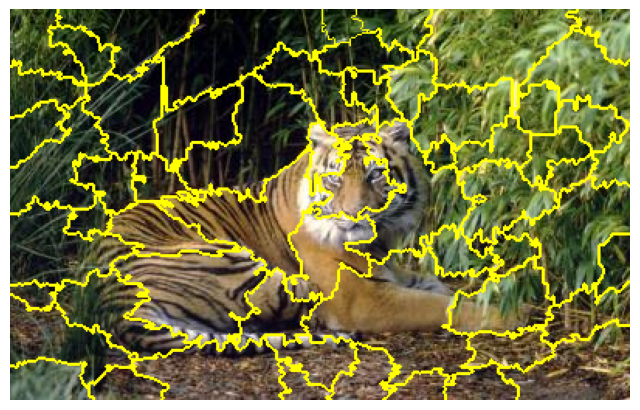

32/32 [==============================] - 99s 3s/step


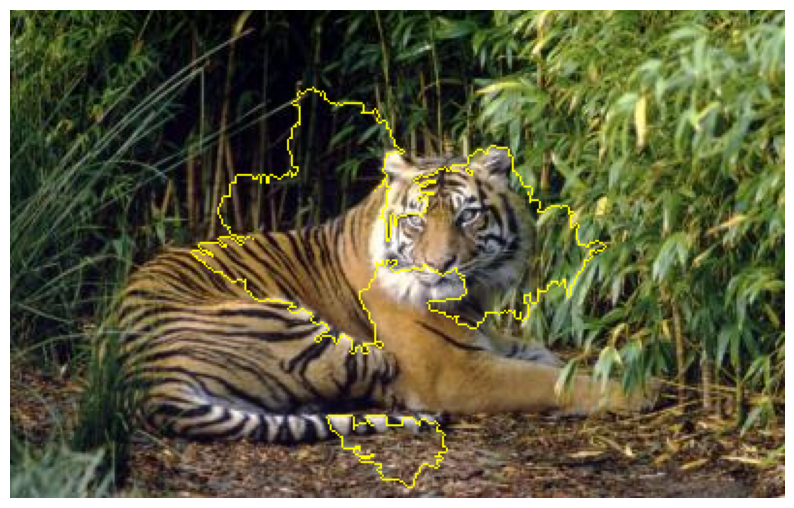

Original image shape: (252, 400, 3)
Mask shape: (252, 400)
Combined segment shape before resize: (252, 400, 3)
1/1 [==============================] - 0s 285ms/step
Top 5 Predicted Classes:
pencil_sharpener: 0.09
lionfish: 0.07
conch: 0.05
black_grouse: 0.03
vase: 0.02


In [9]:
import numpy as np
import copy
import cv2
from skimage.segmentation import quickshift, mark_boundaries
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
import json
from tqdm.auto import tqdm

# Load model and class names
model = InceptionV3(weights='imagenet', include_top=True)
with open("imagenet_class_index.json") as f:
    class_names = json.load(f)

# Step 1: Generate Superpixel Areas
def generate_superpixels(image):
    resized_image = cv2.resize(image, (299, 299))
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    superpixels = quickshift(resized_image_rgb, kernel_size=4, max_dist=200, ratio=0.2)
    return superpixels

# Step 2: Create Perturbed Images and Data Labels
def data_labels(image, superpixels, num_samples, distance_metric='cosine', kernel_width=None):
    resized_image = cv2.resize(image, (299, 299))
    n_features = np.unique(superpixels).shape[0]
    data = np.random.randint(0, 2, num_samples * n_features).reshape((num_samples, n_features))
    data[0, :] = 1  

    perturbed_images = []
    fudged_image = resized_image.copy()
    for x in np.unique(superpixels):
        fudged_image[superpixels == x] = np.mean(resized_image[superpixels == x], axis=0)

    for row in data:
        temp = copy.deepcopy(resized_image)
        zeros = np.where(row == 0)[0]
        for z in zeros:
            temp[superpixels == z] = fudged_image[superpixels == z]
        perturbed_images.append(temp)

    perturbed_images = np.array(perturbed_images)
    images_preprocessed = preprocess_input(perturbed_images)
    predictions = model.predict(images_preprocessed)

    distances = pairwise_distances(data, data[0].reshape(1, -1), metric='cosine').ravel()
    if kernel_width is None:
        kernel_width = np.sqrt(n_features) * 0.25
    weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))

    return data, predictions, weights

# Step 3: Fit a Simple Interpretable Model
def fit_interpretable_model(data, predictions, weights):
    model = Ridge(alpha=0, fit_intercept=True)
    model.fit(data, predictions, sample_weight=weights)
    return model

# Step 4: Identify Important Superpixels
def plot_important_segments(image, superpixels, model, num_segments_to_plot=5):
    coefs = model.coef_[0]
    top_features = np.argsort(np.abs(coefs))[::-1][:num_segments_to_plot]

    mask = np.zeros_like(superpixels)
    for feature in top_features:
        mask[superpixels == feature] = 1

    resized_mask = cv2.resize(mask.astype(np.uint8), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(10, 10))
    plt.imshow(mark_boundaries(image, resized_mask))
    plt.axis('off')
    plt.show()

    return resized_mask


original_image = cv2.imread('Image/tiger-n02129604/n02129604_1055.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
superpixels = generate_superpixels(original_image)

# Plotting superpixels
def plot_superpixel_image(image, superpixels):
    superpixels_resized = cv2.resize(superpixels, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(image, superpixels_resized))
    plt.axis('off')
    plt.show()

plot_superpixel_image(original_image, superpixels)

# perturbed images and labels
num_samples = 1000
distance_metric = 'cosine' 
kernel_width = None  

data, predictions, weights = data_labels(original_image, superpixels, num_samples, distance_metric)


interpretable_model = fit_interpretable_model(data, predictions, weights)


mask = plot_important_segments(original_image, superpixels, interpretable_model)


print(f"Original image shape: {original_image.shape}")
print(f"Mask shape: {mask.shape}")
combined_segment = mask[:, :, np.newaxis] * original_image
print(f"Combined segment shape before resize: {combined_segment.shape}")

combined_segment_resized = cv2.resize(combined_segment, (299, 299))
combined_segment_preprocessed = preprocess_input(combined_segment_resized)
combined_segment_predictions = model.predict(np.expand_dims(combined_segment_preprocessed, axis=0))

top_predicted_classes = np.argsort(-combined_segment_predictions[0])[:5]
print("Top 5 Predicted Classes:")
for idx in top_predicted_classes:
    class_name = class_names[str(idx)][1]
    probability = combined_segment_predictions[0][idx]
    print(f"{class_name}: {probability:.2f}")


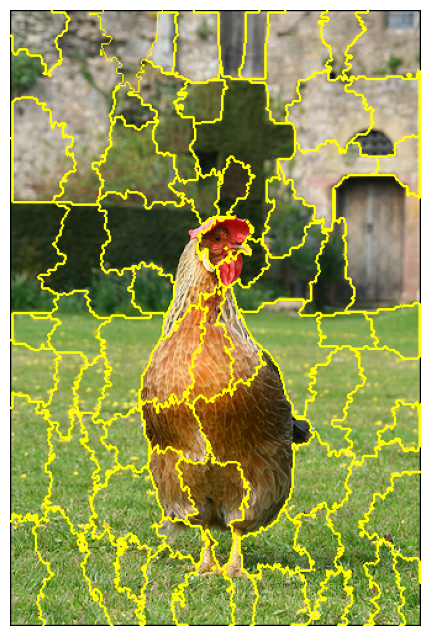

32/32 [==============================] - 121s 4s/step


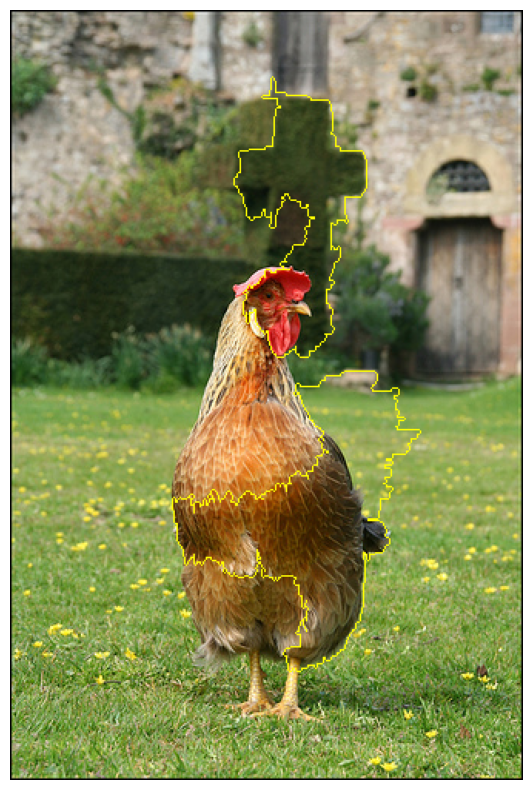

Original image shape: (500, 333, 3)
Mask shape: (500, 333)
Combined segment shape before resize: (500, 333, 3)
1/1 [==============================] - 0s 239ms/step
Top 5 Predicted Classes:
coral_fungus: 0.19
hoopskirt: 0.04
pot: 0.04
pencil_sharpener: 0.03
cocker_spaniel: 0.03


In [5]:
import numpy as np
import copy
import cv2
from skimage.segmentation import quickshift, mark_boundaries
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
import json
from tqdm.auto import tqdm

# Load model and class names
model = InceptionV3(weights='imagenet', include_top=True)
with open("imagenet_class_index.json") as f:
    class_names = json.load(f)

# Step 1: Generate Superpixel Areas
def generate_superpixels(image):
    resized_image = cv2.resize(image, (299, 299))
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    superpixels = quickshift(resized_image_rgb, kernel_size=4, max_dist=200, ratio=0.2)
    return superpixels

# Step 2: Create Perturbed Images and Data Labels
def data_labels(image, superpixels, num_samples, distance_metric='cosine', kernel_width=None):
    resized_image = cv2.resize(image, (299, 299))
    n_features = np.unique(superpixels).shape[0]
    data = np.random.randint(0, 2, num_samples * n_features).reshape((num_samples, n_features))
    data[0, :] = 1  # Original image

    perturbed_images = []
    fudged_image = resized_image.copy()
    for x in np.unique(superpixels):
        fudged_image[superpixels == x] = np.mean(resized_image[superpixels == x], axis=0)

    for row in data:
        temp = copy.deepcopy(resized_image)
        zeros = np.where(row == 0)[0]
        for z in zeros:
            temp[superpixels == z] = fudged_image[superpixels == z]
        perturbed_images.append(temp)

    perturbed_images = np.array(perturbed_images)
    images_preprocessed = preprocess_input(perturbed_images)
    predictions = model.predict(images_preprocessed)

    distances = pairwise_distances(data, data[0].reshape(1, -1), metric=distance_metric).ravel()

    # Calculate weights using a Gaussian kernel
    if kernel_width is None:
        kernel_width = np.sqrt(n_features) * 0.75
    weights = np.exp(-(distances ** 2) / (2 * kernel_width ** 2))

    return data, predictions, weights


# Step 3: Fit a Simple Interpretable Model
def fit_interpretable_model(data, predictions, weights):
    interpretable_model = Ridge(alpha=0, fit_intercept=True)
    interpretable_model.fit(data, predictions, sample_weight=weights)
    return interpretable_model

# Step 4: Identify Important Superpixels
def plot_important_superpixels(image, superpixels, model, num_superpixels_to_plot=5):
    coefs = model.coef_[0]
    top_superpixels = np.argsort(np.abs(coefs))[::-1][:num_superpixels_to_plot]

    mask = np.zeros_like(superpixels)
    for superpixel in top_superpixels:
        mask[superpixels == superpixel] = 1

    resized_mask = cv2.resize(mask.astype(np.uint8), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(10, 10))
    plt.imshow(mark_boundaries(image, resized_mask))
    plt.axis('off')
    plt.show()

    return resized_mask

# Load and preprocess the original image
original_image = cv2.imread('Image/cock-n01514668/n01514668_1208.JPEG')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
superpixels = generate_superpixels(original_image)

# Plot superpixels
def plot_superpixels(image, superpixels):
    superpixels_resized = cv2.resize(superpixels, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(image, superpixels_resized))
    plt.axis('off')
    plt.show()

plot_superpixels(original_image, superpixels)

# Create perturbed images and labels
num_samples = 1000
distance_metric = 'euclidean'  # Customizable distance metric

data, predictions, weights = data_labels(original_image, superpixels, num_samples, distance_metric)

# Fit the interpretable model
interpretable_model = fit_interpretable_model(data, predictions, weights)

# Plot the important superpixels
important_superpixels_mask = plot_important_superpixels(original_image, superpixels, interpretable_model)

# Get the top predictions
print(f"Original image shape: {original_image.shape}")
print(f"Mask shape: {important_superpixels_mask.shape}")
combined_segment = important_superpixels_mask[:, :, np.newaxis] * original_image
print(f"Combined segment shape before resize: {combined_segment.shape}")

combined_segment_resized = cv2.resize(combined_segment, (299, 299))
combined_segment_preprocessed = preprocess_input(combined_segment_resized)
combined_segment_predictions = model.predict(np.expand_dims(combined_segment_preprocessed, axis=0))

top_predicted_classes = np.argsort(-combined_segment_predictions[0])[:5]
print("Top 5 Predicted Classes:")
for idx in top_predicted_classes:
    class_name = class_names[str(idx)][1]
    probability = combined_segment_predictions[0][idx]
    print(f"{class_name}: {probability:.2f}")
